In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

## Read Data For WA, NY, TX, CA and from 2018 to 2022

In [2]:
# Navigate up one level from the current directory
parent_dir = os.path.dirname(os.getcwd())

# Define the relative path to the Parquet file from the parent directory
relative_path = r"analyticsDF.parquet"

# Concatenate the parent directory path and the relative path to get the full path
full_path = os.path.join(parent_dir, relative_path)

In [3]:
df = pd.read_parquet(full_path)
df = df[df.loc[:,'state_code']!='CA']

In [4]:
#df.info(verbose = True, show_counts=True)

In [5]:
# size of dataset
len(df)

6398737

In [6]:
df.columns

Index(['activity_year', 'lei', 'derived_msa_md', 'state_code', 'county_code',
       'census_tract', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_ethnicity', 'derived_race',
       'derived_sex', 'action_taken', 'purchaser_type', 'preapproval',
       'loan_type', 'loan_purpose', 'lien_status', 'reverse_mortgage',
       'open_end_line_of_credit', 'business_or_commercial_purpose',
       'loan_amount', 'combined_loan_to_value_ratio', 'interest_rate',
       'rate_spread', 'hoepa_status', 'total_loan_costs',
       'total_points_and_fees', 'origination_charges', 'discount_points',
       'lender_credits', 'loan_term', 'prepayment_penalty_term',
       'intro_rate_period', 'negative_amortization', 'interest_only_payment',
       'balloon_payment', 'other_nonamortizing_features', 'property_value',
       'construction_method', 'occupancy_type', 'total_units',
       'multifamily_affordable_units', 'income', 'debt_to_income_ratio',
    

In [7]:
df = df.loc[df['county_code'].astype(str).str.startswith(('53', '36', '48'))]

In [8]:
# size of dataset
len(df)

6319224

## Drop rows due to inconclusive dependent variable

In [9]:
# Values:

#     1 - 1 Loan originated
#     2 - 1 Application approved but not accepted
#     3 - 0 Application denied
#     4 - *drop* Application withdrawn by applicant
#     5 - *drop* File closed for incompleteness
#     6 - 1 Purchased loan
#     7 - 0 Preapproval request denied
#     8 - 1 Preapproval request approved but not accepted

selected = df.loc[:, 'action_taken'].isin(['4', '5'])
df = df[~selected]
len(df)

5360384

In [10]:
# Create dependate binary variable

accepted_selected = df.loc[:, 'action_taken'].isin(['1', '2', '6', '8'])
df.loc[:, 'application_approved'] = 0  # Default value is 0

# Update rows where accepted_selected is True
df.loc[accepted_selected, 'application_approved'] = 1

In [11]:
df.application_approved.value_counts(normalize= True)

application_approved
1    0.898433
0    0.101567
Name: proportion, dtype: float64

## Cleaning Features

In [12]:
#conbination of race and ethinicty to no leave out hispanic or latino

df['race_ethnicity'] = df['derived_race'].str.cat(df['derived_ethnicity'], sep='|')

# how many categroies were created
len(df.race_ethnicity.value_counts(dropna=False))

45

### Keep Columns of Interest

In [13]:
# Keep columns of interest
df = df.loc[:, ['application_approved', 'race_ethnicity','county_code', 'derived_sex', 'income', 'applicant_age', 'loan_amount', 'property_value', 'loan_term', 'interest_rate', 'state_code', 'activity_year', 'occupancy_type','denial_reasons']]

In [14]:

blank_counts = df.isna().sum()

# Get total number of rows
total_rows = len(df)

# Show summary
print("Summary of blanks per column:")
for column, blank_count in blank_counts.items():
    print(f"{column}: {blank_count}")


Summary of blanks per column:
application_approved: 0
race_ethnicity: 0
county_code: 0
derived_sex: 0
income: 767047
applicant_age: 0
loan_amount: 0
property_value: 108285
loan_term: 13850
interest_rate: 570665
state_code: 0
activity_year: 0
occupancy_type: 0
denial_reasons: 0


In [15]:
df.columns

Index(['application_approved', 'race_ethnicity', 'county_code', 'derived_sex',
       'income', 'applicant_age', 'loan_amount', 'property_value', 'loan_term',
       'interest_rate', 'state_code', 'activity_year', 'occupancy_type',
       'denial_reasons'],
      dtype='object')

In [16]:
df.application_approved.value_counts()

application_approved
1    4815946
0     544438
Name: count, dtype: int64

In [17]:
df.derived_sex.unique()

array(['Male', 'Female', 'Joint', 'Sex Not Available'], dtype=object)

In [18]:
df['derived_sex'] = df['derived_sex'].replace({'Sex Not Available': 'Prefer not to say'})

In [19]:
df.race_ethnicity.unique()

array(['Race Not Available|Hispanic or Latino',
       'Race Not Available|Ethnicity Not Available',
       'White|Ethnicity Not Available', 'Asian|Not Hispanic or Latino',
       'White|Not Hispanic or Latino',
       'Black or African American|Not Hispanic or Latino',
       'Race Not Available|Not Hispanic or Latino',
       'Asian|Ethnicity Not Available', 'White|Hispanic or Latino',
       'American Indian or Alaska Native|Ethnicity Not Available',
       'Black or African American|Ethnicity Not Available',
       'Joint|Not Hispanic or Latino', 'White|Joint', 'Joint|Joint',
       'Race Not Available|Joint',
       '2 or more minority races|Ethnicity Not Available',
       'Native Hawaiian or Other Pacific Islander|Not Hispanic or Latino',
       'Joint|Ethnicity Not Available', 'Black or African American|Joint',
       'Asian|Hispanic or Latino', 'Joint|Hispanic or Latino',
       'American Indian or Alaska Native|Hispanic or Latino',
       'American Indian or Alaska Native|Not

In [20]:
df['race_ethnicity'] = df['race_ethnicity'].replace({'Race Not Available|Hispanic or Latino': 'Hispanic or Latino',
'Race Not Available|Ethnicity Not Available': 'Missing',
'White|Ethnicity Not Available': 'White',
'Asian|Not Hispanic or Latino': 'Asian',
'White|Not Hispanic or Latino': 'White',
'Black or African American|Not Hispanic or Latino': 'African American',
'Race Not Available|Not Hispanic or Latino': 'Other',
'Joint|Not Hispanic or Latino': 'Joint', 
'White|Hispanic or Latino': 'Hispanic or Latino',
'Asian|Ethnicity Not Available': 'Asian',
'American Indian or Alaska Native|Ethnicity Not Available': 'Native American',
'Black or African American|Ethnicity Not Available': 'African American', 
'White|Joint': 'Joint',
'Joint|Joint': 'Joint', 
'Race Not Available|Joint': 'Joint',
'2 or more minority races|Ethnicity Not Available': 'Other',
'Native Hawaiian or Other Pacific Islander|Not Hispanic or Latino': 'Pacific Islander',
'Asian|Joint': 'Joint', 
'2 or more minority races|Not Hispanic or Latino': 'Other',
'2 or more minority races|Hispanic or Latino': 'Hispanic or Latino',
'Joint|Ethnicity Not Available': 'Joint', 
'Black or African American|Joint': 'Joint',
'Asian|Hispanic or Latino': 'Hispanic or Latino',
'Native Hawaiian or Other Pacific Islander|Ethnicity Not Available': 'Pacific Islander',
'Joint|Hispanic or Latino': 'Joint',
'American Indian or Alaska Native|Hispanic or Latino': 'Hispanic or Latino',
'American Indian or Alaska Native|Not Hispanic or Latino': 'Native American',
'Native Hawaiian or Other Pacific Islander|Hispanic or Latino': 'Hispanic or Latino',
'Black or African American|Hispanic or Latino': 'Hispanic or Latino',
'Native Hawaiian or Other Pacific Islander|Joint': 'Joint',
'American Indian or Alaska Native|Joint': 'Joint',
'2 or more minority races|Joint': 'Joint',
'Free Form Text Only|Hispanic or Latino': 'Hispanic or Latino',
'Asian|Free Form Text Only': 'Asian', 'White|Free Form Text Only': 'White',
'Free Form Text Only|Joint': 'Joint',
'Black or African American|Free Form Text Only': 'African American',
'Race Not Available|Free Form Text Only': 'Missing',
'Joint|Free Form Text Only': 'Joint',
'Free Form Text Only|Free Form Text Only': 'Missing',
'Free Form Text Only|Not Hispanic or Latino': 'Missing',
'2 or more minority races|Free Form Text Only': 'Other',
'American Indian or Alaska Native|Free Form Text Only': 'Native American',
'Free Form Text Only|Ethnicity Not Available': 'Missing',
'Native Hawaiian or Other Pacific Islander|Free Form Text Only': 'Pacific Islander'})

In [21]:
df['race_ethnicity'].unique()

array(['Hispanic or Latino', 'Missing', 'White', 'Asian',
       'African American', 'Other', 'Native American', 'Joint',
       'Pacific Islander'], dtype=object)

In [22]:
df.applicant_age.unique()

array(['35-44', '45-54', '55-64', '25-34', '65-74', '>74', '<25', '-99',
       '9999'], dtype=object)

In [23]:
df['applicant_age'] = df['applicant_age'].replace({'-99': 'Prefer not to say'})

In [24]:
df[df.isna().any(axis=1)].application_approved.value_counts()

application_approved
1    819535
0    536178
Name: count, dtype: int64

In [25]:
df[(df['property_value']==0) | (df['loan_term']==0) | (df['interest_rate']==0)].application_approved.value_counts()

application_approved
1    82316
Name: count, dtype: int64

In [26]:
# Remove negative ammounts
#fill any nan values in y with 0

df = df.fillna(0)

df = df[df.loc[:,'income']>0]
df = df[df.loc[:,'applicant_age']!='9999']
#Normalized Income

# Apply log transformation using numpy's log1p function
df['income_log'] = np.log1p(df['income'])

# Convert the 'loan_amount' column to float32
df['loan_amount'] = df['loan_amount'].astype('float32')

# Apply log transformation using numpy's log1p function
df['loan_amount_log'] = np.log1p(df['loan_amount'])

# Convert the 'loan_amount' column to float32
df['property_value'] = df['property_value'].astype('float32')
df = df[df.loc[:,'property_value']>0]

# Apply log transformation using numpy's log1p function
df['property_value_log'] = np.log1p(df['property_value'])

# df['interest_rate'] = df['interest_rate'].astype('float32')
# df = df[df['interest_rate']>=0]
# df = df[df['interest_rate']<20]


df['loan_term'] = df['loan_term'].astype('float32')
df = df[df['loan_term']==360]
#df = df[df['loan_term']<1500]

#df['loan_to_value'] = df['loan_amount'] / df['property_value'] 

#df['debt_to_income'] = df['loan_amount'] / df['income'] 

df.drop(['income', 'loan_amount', 'property_value', 'denial_reasons', 'activity_year','interest_rate','loan_term'], axis=1, inplace=True) 

# size of dataset
len(df)

3852425

In [27]:
df.replace([np.inf, -np.inf], 0, inplace=True)

In [28]:
df.application_approved.value_counts(normalize=True)

application_approved
1    0.923724
0    0.076276
Name: proportion, dtype: float64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3852425 entries, 0 to 9712775
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   application_approved  int64  
 1   race_ethnicity        object 
 2   county_code           object 
 3   derived_sex           object 
 4   applicant_age         object 
 5   state_code            object 
 6   occupancy_type        object 
 7   income_log            float64
 8   loan_amount_log       float32
 9   property_value_log    float32
dtypes: float32(2), float64(1), int64(1), object(6)
memory usage: 293.9+ MB


In [30]:
df.describe().T.to_clipboard()

In [31]:
# Create DataFrames from arrays
df_race_ethnicity = pd.DataFrame(df.race_ethnicity.unique(), columns=['race_ethnicity'])
df_county_code = pd.DataFrame(df.county_code.unique(), columns=['county_code'])
df_derived_sex = pd.DataFrame(df.derived_sex.unique(), columns=['derived_sex'])
df_applicant_age = pd.DataFrame(df.applicant_age.unique(), columns=['applicant_age'])
#df_loan_term = pd.DataFrame(df.loan_term.unique(), columns=['loan_term'])
df_state_code = pd.DataFrame(df.state_code.unique(), columns=['state_code'])
df_occupancy_type = pd.DataFrame(df.occupancy_type.unique(), columns=['occupancy_type'])



# Concatenate DataFrames column-wise
concatenated_df = pd.concat([df_race_ethnicity, df_county_code,df_derived_sex,df_applicant_age,df_state_code,df_occupancy_type], axis=1)
concatenated_df.to_csv(parent_dir + "\\unique_options.csv", index=False)


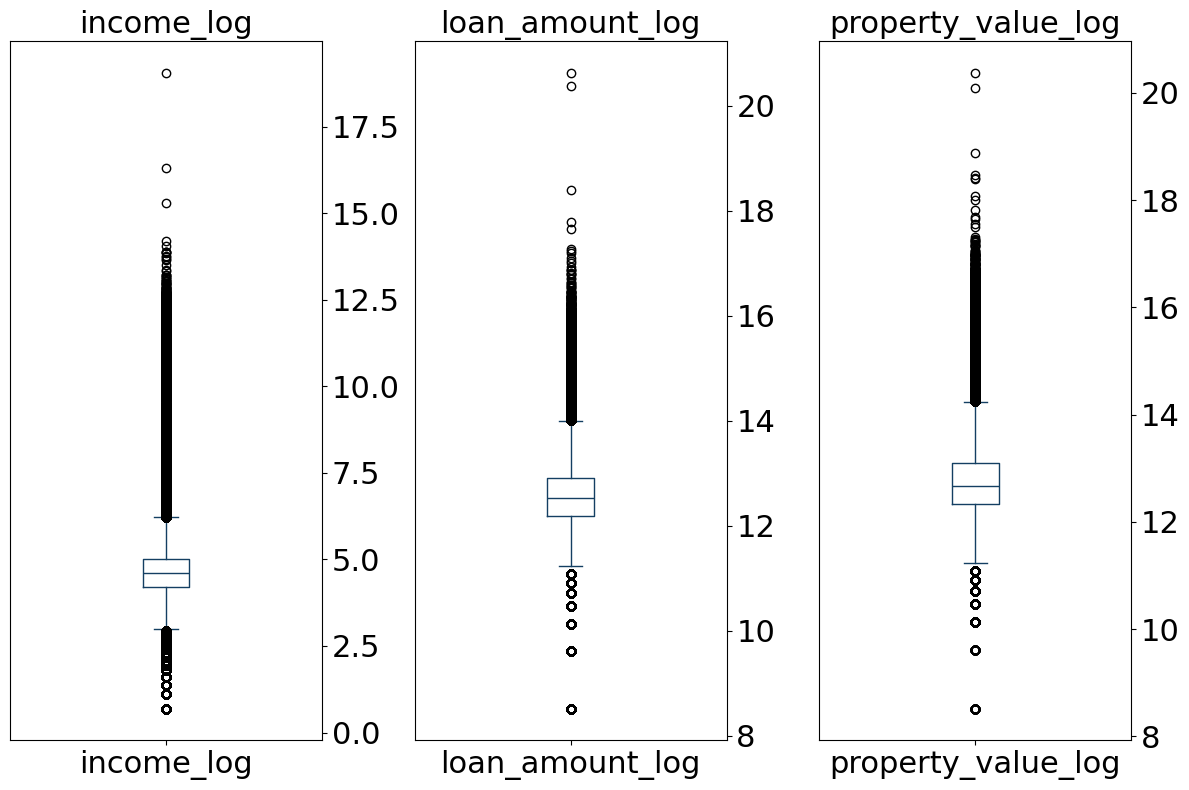

In [35]:
import matplotlib.pyplot as plt

float_cols = df.select_dtypes(include=['float'])

# Creating subplots with separate y-axes
fig, axes = plt.subplots(nrows=1, ncols=float_cols.shape[1], figsize=(12, 8), sharey=False)

# Loop through each column and create box plot
for i, col in enumerate(float_cols.columns):
    ax = float_cols[col].plot(kind='box', ax=axes[i], vert=True, color='#143F62')
    ax.yaxis.tick_right()  # Move y-axis to the right
    axes[i].set_title(col, fontsize=22)  # Increase font size to 18 for title

# Increase font size for tick labels
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=22)

# Showing the plot
plt.tight_layout()
plt.show()


In [36]:
nonoutlier = df[~((df['income_log']>6) | (df['loan_amount_log']>14) | (df['property_value_log']>14))]
nonoutlier = nonoutlier[(nonoutlier['income_log']>3)]

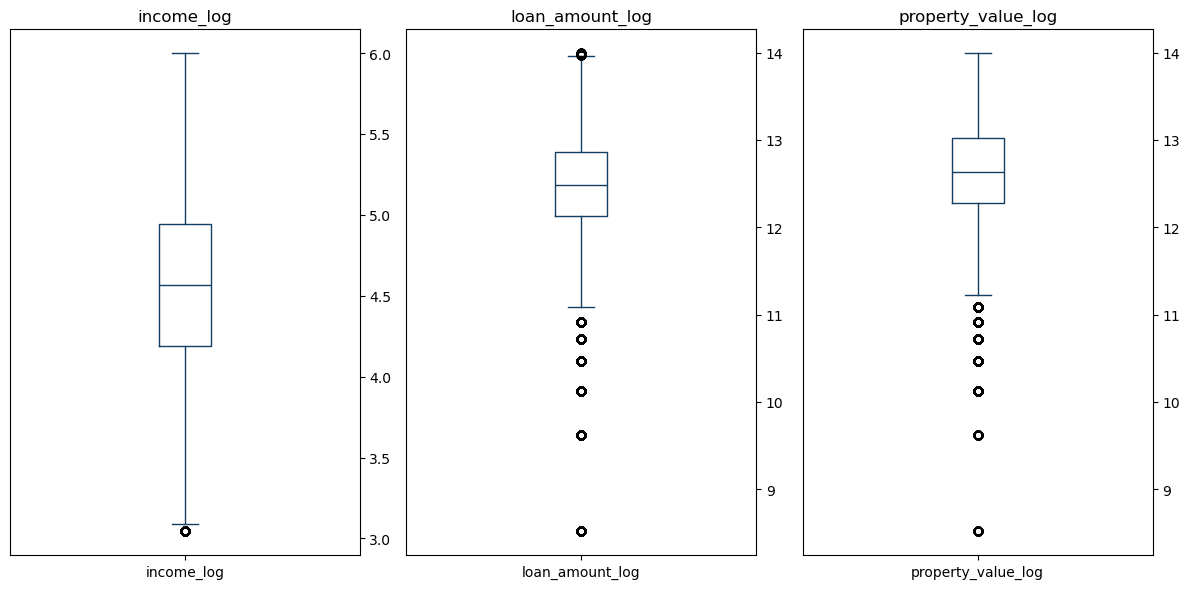

In [37]:
float_cols = nonoutlier.select_dtypes(include=['float'])

float_cols
# Creating subplots with separate y-axes
fig, axes = plt.subplots(nrows=1, ncols=float_cols.shape[1], figsize=(12, 6), sharey=False)

# Loop through each column and create box plot
for i, col in enumerate(float_cols.columns):
    ax = float_cols[col].plot(kind='box', ax=axes[i], vert=True, color='#143F62')
    ax.yaxis.tick_right()  # Move y-axis to the right
    axes[i].set_title(col)

# Showing the plot
plt.tight_layout()
plt.show()

In [38]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_distribution(df):
    """Plot distribution charts for all float columns in the DataFrame.

    Args:
        df (pandas DataFrame): Input DataFrame
    """
    # Select only float columns
    float_cols = df.select_dtypes(include=['float'])

    # Plot distribution for each float column
    for col in float_cols.columns:
        fig, ax = plt.subplots(figsize=(8, 6))
        # Calculate number of bins dynamically
        min_val = df[col].min()
        max_val = df[col].max()
        num_bins = min(3, max_val - min_val)  # Limiting to 20 bins or the range of the data
        ax.hist(df[col], range=(min_val, max_val), color='#143F62', edgecolor='black')
        ax.set_title(f'Distribution of {col}', fontsize=22)  # Increase font size to 22
        ax.set_xlabel(col, fontsize=22)  # Increase font size to 22
        ax.set_ylabel('Frequency', fontsize=22)  # Increase font size to 22
        ax.grid(False)  # Remove gridlines

        # Formatting y-axis labels with commas every 1000 and increase font size
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
        ax.tick_params(axis='both', which='major', labelsize=22)  # Increase tick label font size

        plt.show()


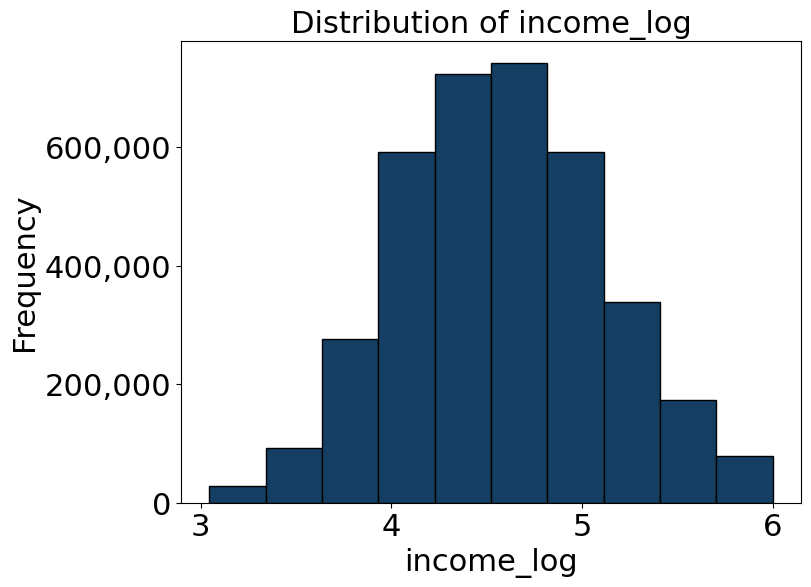

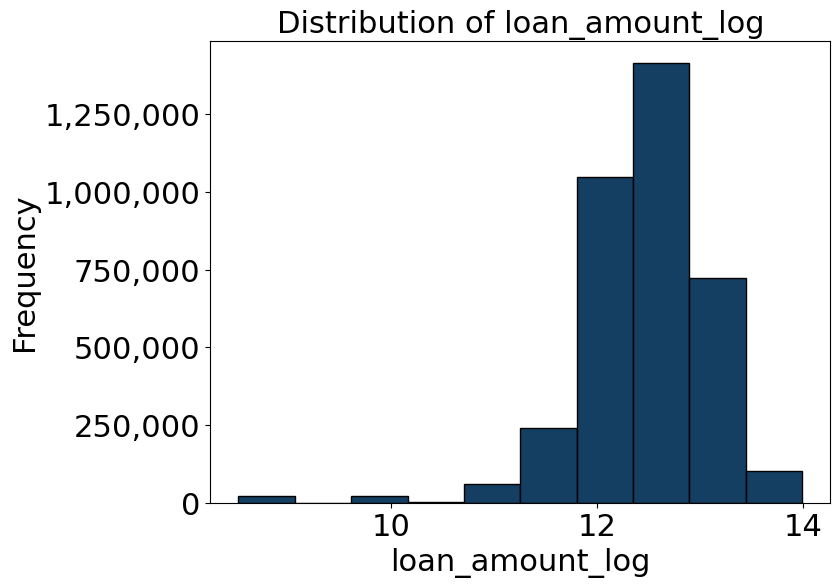

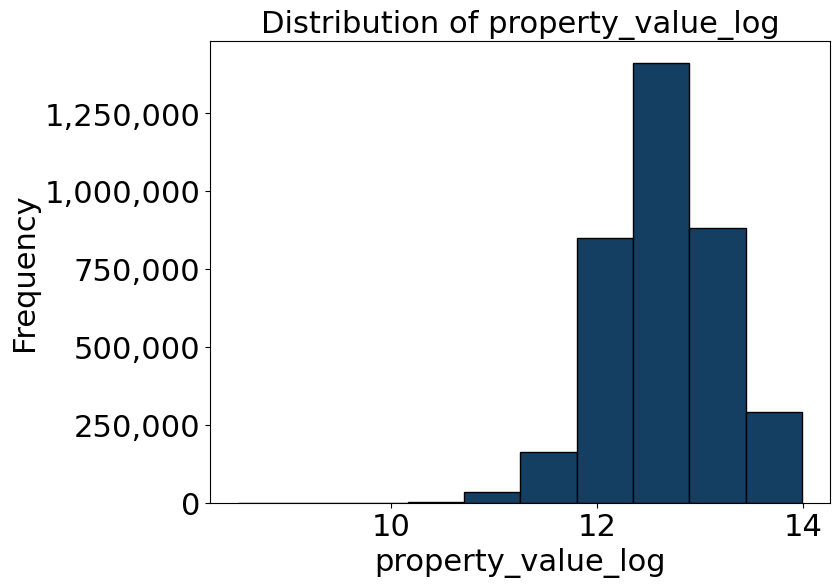

In [39]:
plot_distribution(nonoutlier)

In [82]:
len(nonoutlier)

3636300

In [83]:
nonoutlier.application_approved.value_counts(normalize=True)

application_approved
1    0.925042
0    0.074958
Name: proportion, dtype: float64

In [118]:
nonoutlier.describe().T.to_clipboard()

In [85]:
data_encoded_ref = pd.get_dummies(nonoutlier, columns=['race_ethnicity','occupancy_type', 'derived_sex','applicant_age' ], drop_first=False)

In [86]:
len(data_encoded_ref.columns)

30

In [87]:
list(data_encoded_ref.columns)

['application_approved',
 'county_code',
 'state_code',
 'income_log',
 'loan_amount_log',
 'property_value_log',
 'race_ethnicity_African American',
 'race_ethnicity_Asian',
 'race_ethnicity_Hispanic or Latino',
 'race_ethnicity_Joint',
 'race_ethnicity_Missing',
 'race_ethnicity_Native American',
 'race_ethnicity_Other',
 'race_ethnicity_Pacific Islander',
 'race_ethnicity_White',
 'occupancy_type_Investment',
 'occupancy_type_Principal Residence',
 'occupancy_type_Second Residence',
 'derived_sex_Female',
 'derived_sex_Joint',
 'derived_sex_Male',
 'derived_sex_Prefer not to say',
 'applicant_age_25-34',
 'applicant_age_35-44',
 'applicant_age_45-54',
 'applicant_age_55-64',
 'applicant_age_65-74',
 'applicant_age_<25',
 'applicant_age_>74',
 'applicant_age_Prefer not to say']

In [88]:
data_encoded_ref.memory_usage(deep=True).sum()/ (1024 ** 3)

0.5452374927699566

In [89]:
df.to_parquet(parent_dir + "\\df_small.parquet")
data_encoded_ref.to_parquet(parent_dir + "\\df_small_encoded.parquet")